## Preparazione del Dataset
Il dataset originale utilizzato per l'addestramento è privato. Per eseguire questo codice, è necessario strutturare i propri dati nel seguente formato:

```text
dataset/
└── train/
    ├── sample_001/
    │   ├── rgb.jpg
    │   └── labels.png
    ├── sample_002/
    │   ├── rgb.jpg
    │   └── labels.png
```



In [ ]:
import os
import glob
import torch
import numpy as np
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib

# Definisci la directory base del dataset
# (Modificare questo percorso se si usa un dataset personalizzato)
TRAIN_DIR = "./dataset/train"

In [ ]:
def load_dataset(train_dir):
    dataset = []

    # Sottocartelle dentro la directory di train
    subfolders = sorted([
        f for f in os.listdir(train_dir)
        if os.path.isdir(os.path.join(train_dir, f))
    ])

    for folder in subfolders:
        folder_path = os.path.join(train_dir, folder)
        rgb_path = os.path.join(folder_path, 'rgb.jpg')
        label_path = os.path.join(folder_path, 'labels.png')

        # Verifica che esistano sia l'immagine che la maschera (label)
        if os.path.exists(rgb_path) and os.path.exists(label_path):
            dataset.append((rgb_path, label_path))
        else:
            print(f"⚠️ Mancano file in: {folder}")
            if not os.path.exists(rgb_path):
                print("   - rgb.jpg mancante")
            if not os.path.exists(label_path):
                print("   - labels.png mancante")

    return dataset

In [ ]:
# Creazione della lista contenente le tuple (path_immagine, path_maschera)
if os.path.exists(TRAIN_DIR):
    dataset_paths = load_dataset(TRAIN_DIR)
    print(f"Totale immagini trovate: {len(dataset_paths)}")

    if len(dataset_paths) > 0:
        print("Esempio di percorso:", dataset_paths[0])
else:
    print(f"La directory {TRAIN_DIR} non esiste. Assicurati di aver scaricato e posizionato correttamente il dataset.")

# Analisi distribuzione classi

In [ ]:
from collections import Counter
from tqdm import tqdm

# Mappa semantica delle classi
class_labels = {
    0: "Background",
    1: "Smooth trail",
    2: "Traversable grass",
    3: "Rough trail",
    4: "Puddle",
    5: "Obstacle",
    6: "Non-traversable low vegetation",
    7: "High Vegetation",
    8: "Sky"
}

class_counts = Counter()

print("Calcolo della distribuzione dei pixel per classe...")
# Usiamo dataset_paths (definito in precedenza) e avvolgiamolo con tqdm
for _, label_path in tqdm(dataset_paths, desc="Analisi maschere"):
    label_img = Image.open(label_path)
    labels_np = np.array(label_img)  # converti in array NumPy
    unique, counts = np.unique(labels_np, return_counts=True)
    class_counts.update(dict(zip(unique, counts)))

# Ordina e stampa
print("\n--- Risultati Distribuzione ---")
sorted_counts = sorted(class_counts.items())
for label_class, count in sorted_counts:
    label_name = class_labels.get(label_class, "Unknown")
    print(f"Classe {label_class} ({label_name}): {count:,} pixel")

# ANALISI CORRETTEZZA TRAINING

Data la scarsità di rappresentazione delle classi 4 e 5, si prosegue con la verifica manuale degli esempi corretti, in modo da predisporre l'esecuzione di una Data Augmentation corretta.

Formato: L
Classi presenti: [0 1 4]


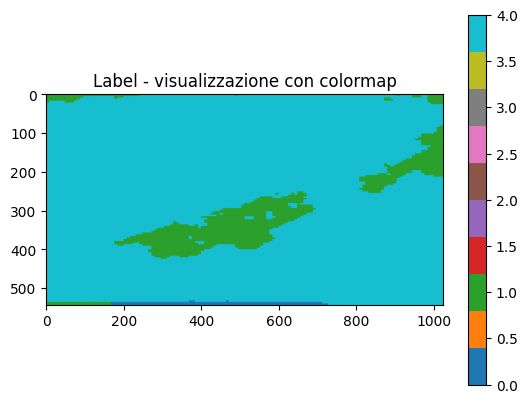

In [ ]:
import matplotlib.pyplot as plt


# Prendiamo dinamicamente il primo elemento dalla nostra lista di file
sample_rgb_path, sample_label_path = dataset_paths[0]

# Carica sia l'immagine originale che la label
rgb_img = Image.open(sample_rgb_path)
label_img = Image.open(sample_label_path)

np_label = np.array(label_img)

print("Formato Maschera:", label_img.mode)
print("Classi presenti in questa maschera:", np.unique(np_label))

# Visualizzazione affiancata per un impatto migliore
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Immagine RGB
axes[0].imshow(rgb_img)
axes[0].set_title("Immagine Originale (RGB)")
axes[0].axis('off') # Nascondiamo gli assi per pulizia visiva

# Plot Maschera (Label)
# Usiamo vmin=0 e vmax=8 in modo che i colori di tab10 siano sempre coerenti con le tue 9 classi
cax = axes[1].imshow(np_label, cmap='tab10', vmin=0, vmax=8)
axes[1].set_title("Maschera di Segmentazione")
axes[1].axis('off')

# Aggiungiamo la colorbar associata alla maschera
fig.colorbar(cax, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

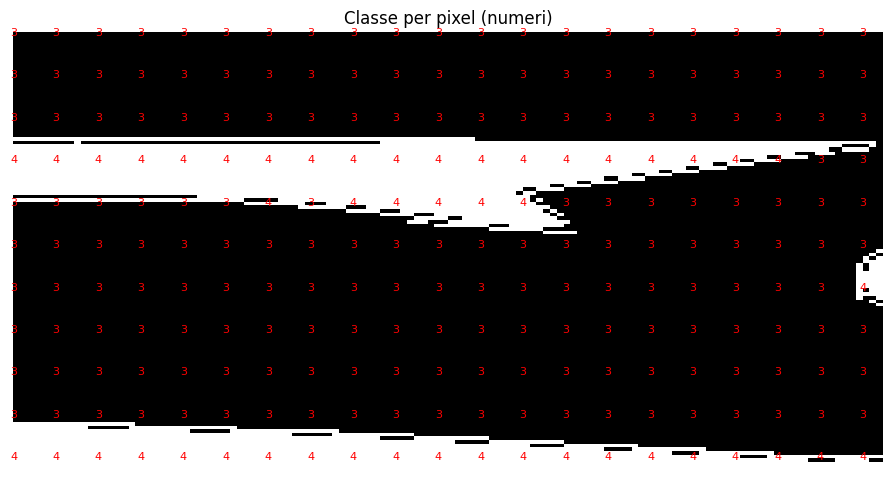

In [ ]:

# Plot base
plt.figure(figsize=(12, 6))
# Interpolation='nearest' è perfetto per le maschere, evita sfumature tra i valori interi
plt.imshow(np_label, cmap='gray', interpolation='nearest')
plt.title("Valori numerici delle classi per pixel")

# Scriviamo il numero su alcuni pixel (distanziati per non sovrapporsi)
step = 50  # Modifica questo valore in base alla risoluzione delle tue immagini
for y in range(0, np_label.shape[0], step):
    for x in range(0, np_label.shape[1], step):
        val = np_label[y, x]
        # Stampiamo il valore in rosso per farlo risaltare sul grigio
        plt.text(x, y, str(val), ha='center', va='center', fontsize=8, color='red')

plt.axis('off')
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

def preview_images_with_class(dataset_dir, target_class=4):
    """
    Scorre tutte le sottocartelle del dataset e visualizza solo quelle contenenti
    la classe specificata. Nessuna interazione, solo preview.
    """
    all_folders = sorted([
        f for f in os.listdir(dataset_dir)
        if os.path.isdir(os.path.join(dataset_dir, f))
    ])

    colormap = ListedColormap([
        '#ffffff',  # 0 - bianco (sfondo)
        '#e0be93',  # 1 - beige
        '#a0ff95',  # 2 - verde chiaro
        '#5e3f20',  # 3 - marrone
        '#ff00ff',  # 4 - fucsia
        '#ff0000',  # 5 - rosso
        '#4fbf4f',  # 6 - verde medio
        '#006400',  # 7 - verde scuro
        '#0000ff',  # 8 - blu
    ])

    print(f"📂 Scansione cartella: {dataset_dir}")
    print(f"🔎 Cerco immagini che contengono la classe {target_class}...\n")

    for folder in all_folders:
        folder_path = os.path.join(dataset_dir, folder)
        label_path = os.path.join(folder_path, "labels.png")
        rgb_path = os.path.join(folder_path, "rgb.jpg")

        if not (os.path.isfile(label_path) and os.path.isfile(rgb_path)):
            continue

        label = np.array(Image.open(label_path))
        if target_class not in np.unique(label):
            continue

        rgb = Image.open(rgb_path)

        # Visualizza immagine + label
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(rgb)
        axes[0].set_title(f"RGB - {folder}")
        axes[1].imshow(label, cmap=colormap, vmin=0, vmax=8)
        axes[1].set_title(f"Label - classe {target_class} presente")
        for ax in axes: ax.axis('off')
        plt.tight_layout()
        plt.show()

# Richiamiamo la funzione usando il percorso dinamico definito all'inizio del notebook
preview_images_with_class(TRAIN_DIR, target_class=4)

In [ ]:
# Chiamate alla funzione basata sulle cartelle definita nella cella precedente
preview_images_with_class(TRAIN_DIR, target_class=6)
preview_images_with_class(TRAIN_DIR, target_class=5)

def preview_images_with_class_from_list(dataset, target_class=4):
    """
    Mostra le immagini e le label dove è presente una certa classe.
    `dataset` è una lista di tuple (rgb_path, label_path)
    """
    colormap = ListedColormap([
        '#ffffff',  # 0 - bianco (sfondo)
        '#e0be93',  # 1 - beige
        '#a0ff95',  # 2 - verde chiaro
        '#5e3f20',  # 3 - marrone
        '#ff00ff',  # 4 - fucsia
        '#ff0000',  # 5 - rosso
        '#4fbf4f',  # 6 - verde medio
        '#006400',  # 7 - verde scuro
        '#0000ff',  # 8 - blu
    ])

    print(f"🔍 Cerco immagini che contengono la classe {target_class}...\n")

    for rgb_path, label_path in dataset:
        if not (os.path.isfile(label_path) and os.path.isfile(rgb_path)):
            continue

        label = np.array(Image.open(label_path))
        if target_class not in np.unique(label):
            continue

        rgb = Image.open(rgb_path)
        folder_name = os.path.basename(os.path.dirname(label_path))

        # Visualizza immagine + label
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(rgb)
        axes[0].set_title(f"RGB - {folder_name}")
        axes[1].imshow(label, cmap=colormap, vmin=0, vmax=8)
        axes[1].set_title(f"Label - classe {target_class} presente")
        for ax in axes: ax.axis('off')
        plt.tight_layout()
        plt.show()

# Richiamiamo la funzione usando la lista creata all'inizio
preview_images_with_class_from_list(dataset_paths, target_class=5)

Per classe 6

In [ ]:
import shutil
import torchvision.transforms as T

# === CONFIG ===
output_good = "verified/good"
output_bad = "verified/bad"
iou_threshold = 0.2
num_classes = 9
target_class = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === CREAZIONE CARTELLE DESTINAZIONE ===
for folder in [output_good, output_bad]:
    os.makedirs(folder, exist_ok=True)

# === PREPROCESSING ===
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# === CARICA MODELLO ===
# N.B. La classe DeepLabV3PlusStable deve essere definita nelle celle precedenti!
model = DeepLabV3PlusStable(num_classes=num_classes)

# Assicurarsi che il file dei pesi sia presente nella directory o aggiornare il path
model.load_state_dict(torch.load("nome_file.pth", map_location=device)) #caricamento pesi modello addestrato
model = model.to(device)
model.eval()

# === FUNZIONE IOU CLASSE 6 ===
def iou_class(pred, mask, class_id):
    pred_bin = (pred == class_id)
    mask_bin = (mask == class_id)
    intersection = (pred_bin & mask_bin).sum().item()
    union = (pred_bin | mask_bin).sum().item()
    if union == 0:
        return 0.0
    return intersection / union

# === LOOP SULLA LISTA DI PATH ===
# Usiamo dataset_paths che abbiamo definito all'inizio
for img_path, lbl_path in tqdm(dataset_paths, desc="Evaluating"):
    if not os.path.isfile(img_path) or not os.path.isfile(lbl_path):
        continue  # Skippa file mancanti

    label = Image.open(lbl_path)
    gt = torch.from_numpy(np.array(label)).long()

    # Skip se classe 6 non presente nella GT
    if target_class not in torch.unique(gt):
        continue

    image = Image.open(img_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)['out']
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()

    iou = iou_class(pred, gt, target_class)

    # Copia i file nella cartella appropriata
    dest = output_good if iou >= iou_threshold else output_bad
    base_name = os.path.basename(os.path.dirname(img_path))
    dest_folder = os.path.join(dest, base_name)
    os.makedirs(dest_folder, exist_ok=True)

    shutil.copy(img_path, os.path.join(dest_folder, "rgb.jpg"))
    shutil.copy(lbl_path, os.path.join(dest_folder, "labels.png"))

print("✅ Completato (solo immagini con classe 6 analizzate).")

Evaluating: 100%|██████████| 782/782 [00:33<00:00, 23.05it/s]

✅ Completato (solo immagini con classe 6 analizzate).


In [ ]:
# Rimuoviamo gli import ridondanti già caricati all'inizio del notebook

# Usiamo la variabile 'output_bad' definita nella cella precedente
# (che punta a "verified/bad") invece del path hardcodato di Colab
train_dir = output_bad
bad_class6 = load_dataset(train_dir)

print(f"Totale immagini caricate: {len(bad_class6)}")
if len(bad_class6) > 0:
    print("Esempio:", bad_class6[0])
else:
    print("Nessuna immagine con IoU sotto la soglia trovata!")

Totale immagini caricate: 80
Esempio: ('/content/verified/bad/0014/rgb.jpg', '/content/verified/bad/0014/labels.png')


# RIETICHETTATURA

Avviene selezionando un'immagine alla volta, considerando immagini ricolorate a mano in base ad una segmentazione corretta.


In [ ]:
# === Parametri colore → label ===
color_to_label = {
    (255, 0, 229): 4,        # Viola → Classe 4
    (255, 0, 0): 5,          # Rosso → Classe 5
    (254, 0, 0): 5,          # Rosso → Classe 5
    (255, 216, 0): 6,        # Giallo → Classe 6
    (114, 142, 254): 2,      # Azzurrino → Classe 2
    (113, 141, 253): 2,      # Azzurrino → Classe 2
    (128, 64, 0): 3,         # Marrone → Classe 3
    (128, 128, 128): 1,      # Grigio → Classe 1
    (0, 0, 0): 7,            # Nero → Classe 7
    (0, 0, 255): 8           # Blu → Classe 8 (Sky)
}

# === File path (Esempio di applicazione) ===
# Modificare questi percorsi per testare lo script sui propri file
label_original_path = "percorso/alla/tua/labels.png"    # Label originale numerica (P o L)
label_modificata_path = "percorso/alla/tua/labels0.png" # Etichetta modificata a colori
output_path = "percorso/di/output/label_finale.png"     # Etichetta risultante

# Eseguiamo la logica solo se i file esistono, per evitare crash del notebook
if os.path.exists(label_original_path) and os.path.exists(label_modificata_path):
    # === Carica immagini ===
    label_original = np.array(Image.open(label_original_path))
    label_modificata_rgb = np.array(Image.open(label_modificata_path).convert("RGB"))

    # === Copia della label finale
    label_finale = label_original.copy()

    # === Per ogni colore da sostituire
    for colore_rgb, nuova_label in color_to_label.items():
        mask = np.all(label_modificata_rgb == colore_rgb, axis=-1)
        label_finale[mask] = nuova_label

    # === Salva il risultato
    os.makedirs(os.path.dirname(output_path), exist_ok=True) # Crea la cartella se non esiste
    Image.fromarray(label_finale.astype(np.uint8)).save(output_path)
    print("✅ Salvata:", output_path)
else:
    print("⚠️ Inserire i percorsi corretti per testare lo script di rietichettatura.")

✅ Salvata: label_finale.png


Visualizzazione colori presenti nell'immagine

In [ ]:
# === Utility: Estrazione colori unici da una maschera RGB ===
# Usiamo il percorso definito nella cella precedente (o inserisci qui un path valido)
image_to_check = label_modificata_path

if os.path.exists(image_to_check):
    img = Image.open(image_to_check).convert("RGB")

    # Rimodella l'array per avere una lista lineare di pixel (RGB) e trova i valori unici
    colors = np.unique(np.array(img).reshape(-1, 3), axis=0)

    print(f"Colori presenti nell'immagine {os.path.basename(image_to_check)}:")
    for color in colors:
        print(tuple(color))
else:
    print(f"⚠️ Impossibile trovare l'immagine: {image_to_check}. Inserire un percorso valido per testare lo script.")

Colori presenti nell'immagine:
(np.uint8(40), np.uint8(80), np.uint8(0))
(np.uint8(41), np.uint8(80), np.uint8(4))
(np.uint8(42), np.uint8(81), np.uint8(8))
(np.uint8(43), np.uint8(78), np.uint8(0))
(np.uint8(43), np.uint8(82), np.uint8(12))
(np.uint8(44), np.uint8(83), np.uint8(16))
(np.uint8(45), np.uint8(84), np.uint8(20))
(np.uint8(46), np.uint8(77), np.uint8(0))
(np.uint8(46), np.uint8(85), np.uint8(24))
(np.uint8(48), np.uint8(86), np.uint8(28))
(np.uint8(49), np.uint8(87), np.uint8(32))
(np.uint8(50), np.uint8(76), np.uint8(0))
(np.uint8(50), np.uint8(88), np.uint8(36))
(np.uint8(51), np.uint8(89), np.uint8(40))
(np.uint8(52), np.uint8(90), np.uint8(43))
(np.uint8(52), np.uint8(90), np.uint8(44))
(np.uint8(53), np.uint8(74), np.uint8(0))
(np.uint8(53), np.uint8(91), np.uint8(47))
(np.uint8(53), np.uint8(91), np.uint8(48))
(np.uint8(54), np.uint8(91), np.uint8(50))
(np.uint8(55), np.uint8(92), np.uint8(52))
(np.uint8(56), np.uint8(73), np.uint8(0))
(np.uint8(56), np.uint8(93), np

# RIMOZIONE ESEMPI AMBIGUI

In [ ]:
# === Utility: Filtraggio del Dataset (Data Cleaning) ===
# Rimuoviamo gli import ridondanti

def copy_filtered_dataset(dataset_list, blacklist_file="eliminare.txt", output_dir="filtered_train"):
    """
    Crea una copia dei dati filtrati in una nuova directory, mantenendo la struttura per cartelle.
    Questa funzione è utile per rimuovere campioni corrotti o etichettati male
    annotati in una blacklist.
    """
    if not os.path.exists(blacklist_file):
        print(f"⚠️ File blacklist '{blacklist_file}' non trovato. Saltare se non si deve filtrare.")
        return

    with open(blacklist_file) as f:
        # splitlines rimuove in automatico i ritorni a capo
        folders_to_exclude = set(f.read().splitlines())

    os.makedirs(output_dir, exist_ok=True)
    kept_count = 0

    for rgb_path, label_path in dataset_list: # Usiamo la variabile passata come argomento
        folder = os.path.basename(os.path.dirname(rgb_path))

        # Se la cartella è nella blacklist, la ignoriamo
        if folder in folders_to_exclude:
            continue

        # Crea nuova directory nella cartella filtrata
        dest_folder = os.path.join(output_dir, folder)
        os.makedirs(dest_folder, exist_ok=True)

        # Copia i file rgb.jpg e labels.png
        dest_rgb = os.path.join(dest_folder, os.path.basename(rgb_path))
        dest_label = os.path.join(dest_folder, os.path.basename(label_path))

        shutil.copy2(rgb_path, dest_rgb)
        shutil.copy2(label_path, dest_label)

        kept_count += 1

    print(f"✅ Copiati {kept_count} campioni puliti in: {output_dir}/")

# Esempio di utilizzo sul dataset caricato all'inizio del notebook:
# copy_filtered_dataset(dataset_paths, blacklist_file="ELIMINARE.txt", output_dir="dataset/filtered_train")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SPLIT DEL DATASET

Funzioni utili

In [ ]:
import random

# === Utility: Logica avanzata di Splitting del Dataset ===

def normalize_folder_name(folder):
    """Assicura che la stringa sia consistente per il confronto (es. '0099')"""
    return os.path.normpath(folder).strip('/\\')

def get_class_pixel_counts(label_path, num_classes=9):
    """
    Conta i pixel per classe in un'immagine label.
    Ritorna un dizionario {classe: numero_pixel}
    """
    label = np.array(Image.open(label_path))
    counts = np.bincount(label.flatten(), minlength=num_classes)
    return dict(enumerate(counts))

def count_images_per_class(dataset, num_classes=9):
    class_image_counts = np.zeros(num_classes, dtype=np.int32)
    for _, label_path in dataset:
        label = np.array(Image.open(label_path))
        classes_in_image = np.unique(label)
        for cls in classes_in_image:
            if 0 <= cls < num_classes:
                class_image_counts[cls] += 1
    return class_image_counts

def split_pixelwise(dataset, num_classes=9, seed=42, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    random.seed(seed)

    # Step 1: conta pixel per immagine
    image_stats = []
    total_pixel_per_class = np.zeros(num_classes, dtype=np.int64)

    for rgb_path, label_path in dataset:
        pixel_counts = get_class_pixel_counts(label_path, num_classes)
        image_stats.append({
            "paths": (rgb_path, label_path),
            "pixel_counts": pixel_counts
        })
        for cls, count in pixel_counts.items():
            total_pixel_per_class[cls] += count

    # Step 2: calcola target assoluti
    total_pixels = np.sum(total_pixel_per_class)
    train_target_px = total_pixels * train_ratio
    val_target_px = total_pixels * val_ratio
    test_target_px = total_pixels * test_ratio

    current_px = {"train": 0, "val": 0, "test": 0}
    splits = {"train": [], "val": [], "test": []}

    # Step 3: shuffle e assegna immagini finché ogni set raggiunge il target
    random.shuffle(image_stats)

    for item in image_stats:
        rgb_path, label_path = item["paths"]
        pixel_count = sum(item["pixel_counts"].values())

        if current_px["train"] + pixel_count <= train_target_px:
            split = "train"
        elif current_px["val"] + pixel_count <= val_target_px:
            split = "val"
        else:
            split = "test"

        splits[split].append((rgb_path, label_path))
        current_px[split] += pixel_count

    return splits["train"], splits["val"], splits["test"]

def read_folder_list(file_path):
    """Legge una lista di nomi cartella da file (uno per riga)."""
    with open(file_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def build_dataset_from_folders(folder_names, base_path):
    """Costruisce lista (rgb_path, label_path) a partire dai nomi delle cartelle."""
    dataset = []
    for folder in folder_names:
        rgb_path = os.path.join(base_path, folder, 'rgb.jpg')
        label_path = os.path.join(base_path, folder, 'labels.png')
        if os.path.exists(rgb_path) and os.path.exists(label_path):
            dataset.append((rgb_path, label_path))
    return dataset

def split_class_samples(train_file, val_file, test_file, base_path):
    """
    Restituisce i sample train/val/test relativi a una classe (es. 4 o 5)
    e le cartelle già usate da escludere dallo split pixelwise successivo.
    """
    train_folders = read_folder_list(train_file)
    val_folders = read_folder_list(val_file)
    test_folders = read_folder_list(test_file)

    used_folders = set(train_folders + val_folders + test_folders)

    train_data = build_dataset_from_folders(train_folders, base_path)
    val_data = build_dataset_from_folders(val_folders, base_path)
    test_data = build_dataset_from_folders(test_folders, base_path)

    return train_data, val_data, test_data, used_folders

def extract_folder_name(path):
    return os.path.normpath(path).split(os.sep)[-2]

def save_split_file(data, output_file):
    folder_names = [extract_folder_name(rgb_path) for rgb_path, _ in data]
    with open(output_file, 'w') as f:
        for name in sorted(folder_names):
            f.write(f"{name}\n")

SPLIT TRAIN/VAL/TEST

In [ ]:
# === Esecuzione dello Split Ibrido (Manuale + Pixelwise) ===

# I file di testo contengono le liste delle cartelle per le classi rare/critiche
file_tr4, file_vl4, file_ts4 = 'TrainingClasse4.txt', 'ValidationClasse4.txt', 'TestClasse4.txt'
file_tr5, file_vl5, file_ts5 = 'TrainingClasse5.txt', 'ValidationClasse5.txt', 'TestClasse5.txt'

# Eseguiamo solo se i file esistono (per evitare crash se il notebook viene eseguito senza i txt)
if all(os.path.exists(f) for f in [file_tr4, file_vl4, file_ts4, file_tr5, file_vl5, file_ts5]):

    # Split per le classi 4 e 5 basato sui file di testo (passando TRAIN_DIR come base_path)
    train4, val4, test4, used4 = split_class_samples(file_tr4, file_vl4, file_ts4, base_path=TRAIN_DIR)
    train5, val5, test5, used5 = split_class_samples(file_tr5, file_vl5, file_ts5, base_path=TRAIN_DIR)

    # Combina i risultati delle due classi pre-assegnate
    train_pre = train4 + train5
    val_pre = val4 + val5
    test_pre = test4 + test5
    used_folders = used4.union(used5)

    # Ora facciamo lo split pixelwise solo sulle cartelle non ancora usate
    # Usiamo 'dataset_paths' definito all'inizio del notebook
    remaining_dataset = [item for item in dataset_paths if extract_folder_name(item[0]) not in used_folders]

    # split_pixelwise ritorna il resto dei dati
    train_rest, val_rest, test_rest = split_pixelwise(remaining_dataset)

    # Unisci split manuale + pixelwise
    train_data = train_pre + train_rest
    val_data = val_pre + val_rest
    test_data = test_pre + test_rest

    # --- Stampa Statistiche ---
    print(f"Totale immagini: {len(dataset_paths)}")
    print(f"Training set: {len(train_data)} immagini")
    print(f"Validation set: {len(val_data)} immagini")
    print(f"Test set: {len(test_data)} immagini")

    # Funzione interna per il conteggio dei pixel per split
    def count_class_pixels(dataset_list, num_classes=9):
        total = np.zeros(num_classes, dtype=np.int64)
        for _, label_path in dataset_list:
            counts = get_class_pixel_counts(label_path, num_classes)
            for cls, c in counts.items():
                total[cls] += c
        return total

    print("\nPixel per classe per split:")
    train_pixels = count_class_pixels(train_data)
    val_pixels = count_class_pixels(val_data)
    test_pixels = count_class_pixels(test_data)

    for cls in range(len(train_pixels)):
        print(f"Classe {cls}: Train={train_pixels[cls]}, Val={val_pixels[cls]}, Test={test_pixels[cls]}")

    print("\nNumero di immagini contenenti ciascuna classe:")
    train_image_counts = count_images_per_class(train_data)
    val_image_counts = count_images_per_class(val_data)
    test_image_counts = count_images_per_class(test_data)

    for cls in range(9):
        print(f"Classe {cls}: Train={train_image_counts[cls]}, Val={val_image_counts[cls]}, Test={test_image_counts[cls]}")

    # --- Salvataggio ---
    save_split_file(train_data, "split_train.txt")
    save_split_file(val_data, "split_val.txt")
    save_split_file(test_data, "split_test.txt")
    print("\n✅ File di split ('split_train.txt', 'split_val.txt', 'split_test.txt') salvati con successo!")

else:
    print("⚠️ File di testo per lo split manuale delle classi 4 e 5 non trovati.")
    print("Assicurati di aver caricato i file .txt nella directory corrente per eseguire lo split.")

Totale immagini: 755
Training set: 525 immagini
Validation set: 154 immagini
Test set: 76 immagini

Pixel per classe per split:
Classe 0: Train=7771901, Val=1998049, Test=1154054
Classe 1: Train=44140586, Val=14084315, Test=5996301
Classe 2: Train=42181805, Val=11015182, Test=5450828
Classe 3: Train=41146545, Val=11045556, Test=5667687
Classe 4: Train=433057, Val=124152, Test=122231
Classe 5: Train=1307418, Val=664473, Test=66472
Classe 6: Train=17883661, Val=6415789, Test=3266574
Classe 7: Train=107605165, Val=31941920, Test=16798427
Classe 8: Train=29984262, Val=8497188, Test=3813682

Numero di immagini contenenti ciascuna classe:
Classe 0: Train=525, Val=154, Test=76
Classe 1: Train=325, Val=99, Test=49
Classe 2: Train=373, Val=105, Test=53
Classe 3: Train=277, Val=74, Test=39
Classe 4: Train=22, Val=8, Test=5
Classe 5: Train=87, Val=27, Test=12
Classe 6: Train=183, Val=62, Test=29
Classe 7: Train=522, Val=154, Test=76
Classe 8: Train=482, Val=139, Test=70


# CARICAMENTO SET SPLITTATI

In [ ]:
# === CARICAMENTO SET SPLITTATI ===
# (Le funzioni `read_folder_list` e `build_dataset_from_folders`
# sono già definite in memoria dalla cella di utility precedente)

# 📁 Usiamo la directory base coerente con il resto del notebook
base_path = TRAIN_DIR

split_files = ["split_train.txt", "split_val.txt", "split_test.txt"]

# 🔄 Eseguiamo solo se i file di split esistono effettivamente
if all(os.path.exists(f) for f in split_files):

    # 📄 Carica i nomi delle cartelle dai file di split salvati
    train_folders = read_folder_list("split_train.txt")
    val_folders = read_folder_list("split_val.txt")
    test_folders = read_folder_list("split_test.txt")

    # 🔄 Ricostruisce le tuple (rgb_path, label_path) da ciascun gruppo
    train_data = build_dataset_from_folders(train_folders, base_path)
    val_data = build_dataset_from_folders(val_folders, base_path)
    test_data = build_dataset_from_folders(test_folders, base_path)

    # 📊 Stampa di verifica
    print("✅ File di split letti e dataset caricati con successo!")
    print(f"Train: {len(train_data)} immagini")
    print(f"Val:   {len(val_data)} immagini")
    print(f"Test:  {len(test_data)} immagini")

else:
    print("⚠️ File di split non trovati ('split_train.txt', ecc.).")
    print("Esegui la cella di splitting precedente per generarli prima di caricarli.")

Train: 543 immagini
Val:   159 immagini
Test:  80 immagini


# DEFINIZIONE CLASSE PER DATASET

La classe TensorSegmentationDataset permette di costruire Dataset a partire dalle liste di dati caricati. Inoltre permette di applicare una serie di trasformazioni per eseguire Data Augmentation. Questa sarà applicata solo sul dataset di training.

In [ ]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torch

# === CLASSE DATASET CUSTOM E DATA AUGMENTATION ===

class TensorSegmentationDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform  # Funzione opzionale per la Data Augmentation

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rgb_path, label_path = self.data[idx]

        # Carica immagine e label
        rgb = Image.open(rgb_path).convert("RGB")
        label = Image.open(label_path)

        # Resize
        target_size = (432, 768)
        rgb = TF.resize(rgb, target_size, interpolation=TF.InterpolationMode.BILINEAR)
        label = TF.resize(label, target_size, interpolation=TF.InterpolationMode.NEAREST)

        # Converti in tensor
        rgb_tensor = TF.to_tensor(rgb)  # (3, H, W)
        label_tensor = torch.from_numpy(np.array(label)).long()  # (H, W)

        # Normalizzazione (mean e std standard di ImageNet)
        rgb_tensor = TF.normalize(
            rgb_tensor,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        # Applica Data Augmentation se definita
        if self.transform:
            rgb_tensor, label_tensor = self.transform(rgb_tensor, label_tensor)

        return rgb_tensor, label_tensor


def transform_train(img, mask):
    """
    Funzione custom per la Data Augmentation.
    Garantisce che venga applicata almeno una trasformazione per chiamata.
    """
    transformed = False

    while not transformed:

        # 1. Flip orizzontale
        if random.random() < 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)
            transformed = True

        # 2. Color Jitter (Luminosità, Contrasto, Saturazione)
        if random.random() < 0.8:
            brightness = 0.8 + 0.4 * random.random()
            contrast = 0.8 + 0.4 * random.random()
            saturation = 0.8 + 0.4 * random.random()
            img = TF.adjust_brightness(img, brightness)
            img = TF.adjust_contrast(img, contrast)
            img = TF.adjust_saturation(img, saturation)
            transformed = True

        # 3. Rumore Gaussiano
        if random.random() < 0.5:
            noise = torch.randn_like(img) * 0.02
            img = img + noise
            img = torch.clamp(img, 0., 1.)
            transformed = True

        # 4. Rotazione (+- 5 gradi)
        if random.random() < 0.3:
            angle = random.uniform(-5, 5)
            # Unsqueeze necessario per le operazioni batch-like in vecchie versioni TF
            img = img.unsqueeze(0)
            mask = mask.unsqueeze(0)

            img = TF.rotate(img, angle, interpolation=TF.InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=TF.InterpolationMode.NEAREST)

            img = img.squeeze(0)
            mask = mask.squeeze(0)
            transformed = True

        # 5. Traslazione (+- 10 pixel)
        if random.random() < 0.3:
            dx = random.randint(-10, 10)
            dy = random.randint(-10, 10)
            img = img.unsqueeze(0)
            mask = mask.unsqueeze(0)

            img = TF.affine(img, angle=0, translate=(dx, dy), scale=1.0, shear=0)
            mask = TF.affine(mask, angle=0, translate=(dx, dy), scale=1.0, shear=0, interpolation=TF.InterpolationMode.NEAREST)

            img = img.squeeze(0)
            mask = mask.squeeze(0)
            transformed = True

    return img, mask

# FUNZIONI PER DATA AUGMENTATION MIRATO ALLE CLASSI RARE

Conta quanti pixel appartengono alle classi rare, e restituisce la percentuale rispetto al totale.


Args:
      label_tensor (torch.Tensor): label (H, W)
      class_ids (list or set): classi da considerare (es. [4, 5])

Returns:
      num_rare_pixels (int): numero di pixel rari
      ratio (float): percentuale sul totale (tra 0 e 1)

In [ ]:

def count_class_pixels(label_tensor, class_ids):

    labels_np = label_tensor.numpy()
    total_pixels = labels_np.size
    rare_mask = np.isin(labels_np, class_ids) #Crea una maschera booleana (array con True/False) True per ogni pixel che ha una classe contenuta in class_ids False per tutti gli altri pixel
    num_rare_pixels = rare_mask.sum()
    ratio = num_rare_pixels / total_pixels
    return num_rare_pixels, ratio


Estrae un crop casuale contenente pixel delle classi specificate.

    Args:
        rgb_tensor (Tensor): immagine (3, H, W)
        label_tensor (Tensor): etichette (H, W)
        class_ids (list): classi rare da cercare
        crop_size (int): dimensione del crop (quadrato)
        margin (int): margine attorno alla bounding box

    Returns:
        cropped_rgb (Tensor): crop immagine
        cropped_label (Tensor): crop label
        success (bool): True se il crop è stato eseguito


In [ ]:
import torchvision.transforms.functional as TF
import torchvision.transforms as T
from scipy.ndimage import label as connected_components



def extract_random_crop_with_classes(rgb_tensor, label_tensor, class_ids=[4, 5], crop_size=128, output_size=(544, 1024), margin=16, apply_photometric_aug=True, max_attempts=20):


    label_np = label_tensor.numpy()
    H, W = label_np.shape

    # Trova coordinate dei pixel con classi desiderate
    mask = np.isin(label_np, class_ids)
    coords = np.argwhere(mask)

    if len(coords) == 0:
        return None, None, False  # Nessun pixel utile

    # Trova il blob più grande tra i pixel target
    labeled_mask, num_features = connected_components(mask)
    if num_features == 0:
        return None, None, False

    max_blob = None
    max_area = 0
    for i in range(1, num_features + 1):
        area = np.sum(labeled_mask == i)
        if area > max_area:
            max_area = area
            max_blob = i

    blob_coords = np.argwhere(labeled_mask == max_blob)
    y_min, x_min = blob_coords.min(axis=0)
    y_max, x_max = blob_coords.max(axis=0)

    # Espandi la bounding box con margine
    y_min = max(y_min - margin, 0)
    x_min = max(x_min - margin, 0)
    y_max = min(y_max + margin, H)
    x_max = min(x_max + margin, W)

    # I valori minimi rappresentano l'angolo in alto a sinistra
    # I valori massimi rappresentano l'angolo in basso a destra
    # del bounding box quadrato formato attorno ai pixel di interesse

    # provo ad eseguire crop finché non sono sicuro che il crop generato contenga la classe target
    for _ in range(max_attempts):
        if (y_max - y_min) < crop_size or (x_max - x_min) < crop_size:
            return None, None, False  # troppo piccolo per il crop

        crop_top = random.randint(y_min, y_max - crop_size)
        crop_left = random.randint(x_min, x_max - crop_size)

        cropped_rgb = rgb_tensor[:, crop_top:crop_top+crop_size, crop_left:crop_left+crop_size]
        cropped_label = label_tensor[crop_top:crop_top+crop_size, crop_left:crop_left+crop_size]

        # Verifica se il crop contiene almeno un pixel target
        cropped_mask = torch.isin(cropped_label, torch.tensor(class_ids))
        if cropped_mask.any():
            break
    else:
        return None, None, False  # nessun crop valido trovato


    # Ridimensiona al target richiesto
    if output_size:
        cropped_rgb = TF.resize(cropped_rgb, output_size, interpolation=TF.InterpolationMode.BILINEAR)
        cropped_label = TF.resize(cropped_label.unsqueeze(0), output_size, interpolation=TF.InterpolationMode.NEAREST).squeeze(0)


    # Augmentazione fotometrica (profilata)
    if apply_photometric_aug and hasattr(extract_random_crop_with_classes, "illumination_profile"):
        profile = extract_random_crop_with_classes.illumination_profile
        cropped_rgb = TF.adjust_brightness(cropped_rgb, profile['brightness'])
        cropped_rgb = TF.adjust_contrast(cropped_rgb, profile['contrast'])
        cropped_rgb = TF.adjust_saturation(cropped_rgb, profile['saturation'])



    return cropped_rgb, cropped_label, True

Genera campioni augmentati da immagini che contengono un numero sufficiente di pixel delle classi specificate.

    Args:
        train_data (list): lista di (rgb_tensor, label_tensor)
        class_ids (list): classi target per il crop mirato
        n_crops_per_image (int): numero di crop da generare per ogni immagine valida
        crop_size (int): dimensione del crop quadrato
        min_ratio (float): soglia minima di pixel target rispetto al totale (es. 0.005 = 0.5%)

    Returns:
        list of (rgb_tensor, label_tensor): nuovi campioni augmentati


In [ ]:
# === GENERAZIONE CAMPIONI AUMENTATI MIRATI (LUCE/TRAMONTO/NOTTE) ===

def generate_augmented_samples(train_data, class_ids=[4, 5], n_crops_per_image=3, crop_size=128, min_ratio=0.005, save_dir="augmented_train"):

    illumination_profiles = [
        {'brightness': 1.2, 'contrast': 1.0, 'saturation': 1.2},  # Mattina
        {'brightness': 0.5, 'contrast': 0.7, 'saturation': 0.5},  # Notte
        {'brightness': 0.7, 'contrast': 1.3, 'saturation': 1.5},  # Tramonto
    ]

    night_and_day_profiles = [
        illumination_profiles[0],  # Mattina
        illumination_profiles[2],  # Tramonto
    ]

    os.makedirs(save_dir, exist_ok=True)
    counter = 0

    for rgb_path, label_path in train_data:
        rgb = Image.open(rgb_path).convert("RGB")
        label = Image.open(label_path)

        rgb_tensor = TF.to_tensor(rgb)
        label_tensor = torch.from_numpy(np.array(label)).long()

        count, ratio = count_class_pixels(label_tensor, class_ids)

        if ratio < min_ratio:
            continue  # Immagine non significativa per queste classi

        for i in range(n_crops_per_image):
            if 6 in class_ids:
                # Classe 6: scelta casuale tra "mattina" e "tramonto"
                profile = random.choice(night_and_day_profiles)
            else:
                if illumination_profiles and i < len(illumination_profiles):
                    profile = illumination_profiles[i]
                else:
                    profile = {
                        'brightness': 1.0,
                        'contrast': 1.0,
                        'saturation': 1.0
                    }

            # Passaggio del profilo di illuminazione alla funzione di crop (definita altrove)
            extract_random_crop_with_classes.illumination_profile = profile

            crop_rgb, crop_lbl, success = extract_random_crop_with_classes(
                rgb_tensor=rgb_tensor,
                label_tensor=label_tensor,
                class_ids=class_ids,
                crop_size=crop_size,
                output_size=(544, 1024)
            )

            if success:
                folder_path = os.path.join(save_dir, f"{counter:04d}")
                os.makedirs(folder_path, exist_ok=True)

                # Salva come rgb.jpg (JPEG) e labels.png (PNG con etichette)
                TF.to_pil_image(crop_rgb).save(os.path.join(folder_path, "rgb.jpg"), format='JPEG')
                Image.fromarray(crop_lbl.numpy().astype(np.uint8)).save(os.path.join(folder_path, "labels.png"))

                # Salva nome file sorgente per il log
                image_name = os.path.basename(os.path.dirname(rgb_path))

                print(f"[{counter:04d}] Crop salvato da {image_name}")
                counter += 1

    print(f"✅ Salvati {counter} crop augmentati in: {save_dir}")

DATA AUGMENTATION E CREAZIONE DATASET

In [ ]:
# === 1. Esecuzione Data Augmentation Mirata sul Training ===

print("Eseguo data augmentation mirata per la classe 4...")
generate_augmented_samples(
    train_data,          # lista originale di tuple (img, label)
    class_ids=[4],       # classi rare
    n_crops_per_image=3, # numero di crop per immagine valida
    crop_size=128,       # dimensione crop quadrato
    min_ratio=0.05,      # soglia minima di presenza classe rara
    save_dir="augmented_train/class4"
)

print("\nEseguo data augmentation mirata per la classe 5...")
generate_augmented_samples(
    train_data,          # lista originale di tuple (img, label)
    class_ids=[5],       # classi rare
    n_crops_per_image=2, # numero di crop per immagine valida
    crop_size=128,       # dimensione crop quadrato
    min_ratio=0.02,      # soglia minima di presenza classe rara
    save_dir="augmented_train/class5"
)

Eseguo data augmentation mirata per la classe 4...
[0000] Crop salvato da 0339
[0001] Crop salvato da 0339
[0002] Crop salvato da 0339
[0003] Crop salvato da 0511
[0004] Crop salvato da 0511
[0005] Crop salvato da 0511
[0006] Crop salvato da 0659
[0007] Crop salvato da 0659
[0008] Crop salvato da 0659
[0009] Crop salvato da 1149
[0010] Crop salvato da 1149
[0011] Crop salvato da 1149
[0012] Crop salvato da 1164
[0013] Crop salvato da 1164
[0014] Crop salvato da 1164
[0015] Crop salvato da 1146
[0016] Crop salvato da 1146
[0017] Crop salvato da 1146
[0018] Crop salvato da 0718
[0019] Crop salvato da 0718
[0020] Crop salvato da 0718
Salvati 21 crop augmentati in: /content/augmented_train/class4
Eseguo data augmentation mirata per la classe 5...
[0000] Crop salvato da 0002
[0001] Crop salvato da 0002
[0002] Crop salvato da 0063
[0003] Crop salvato da 0063
[0004] Crop salvato da 0127
[0005] Crop salvato da 0127
[0006] Crop salvato da 0165
[0007] Crop salvato da 0165
[0008] Crop salvato da 

AUGMENTATION CON COPY PASTE

In [ ]:

def get_class_ids(label_path):
    label = np.array(Image.open(label_path))
    return set(np.unique(label))


In [ ]:
def collect_image_pairs_from_list(dataset_list):
    """
    Prende una lista di tuple (rgb_path, label_path)
    Restituisce due liste:
        - immagini con classe 3 e senza classe 4
        - immagini con classe 4
    """
    trail_only = []
    puddle_images = []

    for rgb_path, label_path in dataset_list:
        class_ids = get_class_ids(label_path)

        if 3 in class_ids and 4 not in class_ids:
            trail_only.append((rgb_path, label_path))
        elif 4 in class_ids:
            puddle_images.append((rgb_path, label_path))

    return trail_only, puddle_images


In [ ]:


def copy_paste_class4_onto_class3(puddle_img, puddle_mask, trail_img, trail_mask, class4_id=4, class3_id=3):
    """
    Inserisce una pozzanghera (classe 4) dentro un'immagine contenente trail (classe 3)
    """

    # Converti in numpy
    p_img_np = np.array(puddle_img)
    p_mask_np = np.array(puddle_mask)
    t_img_np = np.array(trail_img)
    t_mask_np = np.array(trail_mask)

    # Maschera binaria pozzanghera
    puddle_mask_bin = (p_mask_np == class4_id).astype(np.uint8)

    if puddle_mask_bin.sum() == 0:
        return None, None, False

    # Bounding box della pozzanghera
    ys, xs = np.where(puddle_mask_bin)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    patch_img = p_img_np[y_min:y_max+1, x_min:x_max+1, :]
    patch_mask = p_mask_np[y_min:y_max+1, x_min:x_max+1]
    valid = (patch_mask == class4_id)


    h_patch, w_patch = patch_img.shape[:2]
    h_target, w_target = t_img_np.shape[:2]

    # Dove incollare sul trail?
    trail_area = (t_mask_np == class3_id).astype(np.uint8)
    ys_t, xs_t = np.where(trail_area)

    if len(ys_t) == 0:
        return None, None, False

    # Trova tutte le posizioni dove il patch può stare interamente dentro trail
    valid_positions = []

    for y, x in zip(ys_t, xs_t):
        top = y - h_patch // 2
        left = x - w_patch // 2
        bottom = top + h_patch
        right = left + w_patch

        if top < 0 or left < 0 or bottom > h_target or right > w_target:
            continue

        patch_area = t_mask_np[top:bottom, left:right]
        if np.all(patch_area == class3_id):
            valid_positions.append((top, left))

    if not valid_positions:
        return None, None, False

    top, left = random.choice(valid_positions)

    # Calcola media colore pozzanghera (solo pixel validi nel patch)
    patch_rgb = patch_img[valid]
    patch_mean = patch_rgb.mean(axis=0)

    # Calcola media colore zona target nel trail (solo classe 3)
    target_region = t_img_np[top:top+h_patch, left:left+w_patch, :]
    target_mask = (t_mask_np[top:top+h_patch, left:left+w_patch] == class3_id)
    target_rgb = target_region[target_mask]
    if target_rgb.size == 0:
        return None, None, False  # sicurezza
    target_mean = target_rgb.mean(axis=0)

    # Calcola shift RGB e applica al patch
    color_shift = target_mean - patch_mean
    adjusted_patch = patch_img.astype(np.float32)
    for c in range(3):
        adjusted_patch[:, :, c][valid] += color_shift[c]
        adjusted_patch[:, :, c] = np.clip(adjusted_patch[:, :, c], 0, 255)
    patch_img = adjusted_patch.astype(np.uint8)

    # Copia le immagini
    new_img = t_img_np.copy()
    new_mask = t_mask_np.copy()

    # Solo i pixel che sono pozzanghera nel patch
    valid = (patch_mask == class4_id)

    for c in range(3):
        new_img[top:top+h_patch, left:left+w_patch, c][valid] = patch_img[:, :, c][valid]

    new_mask[top:top+h_patch, left:left+w_patch][valid] = class4_id

    # Converti in PIL
    return Image.fromarray(new_img), Image.fromarray(new_mask), True


In [ ]:
# === 2. Generazione Campioni Sintetici (Copy-Paste Augmentation) ===

def generate_copy_paste_augmented(trail_only, puddle_images, save_dir="augmented_train/mix_3_4", max_samples=100):
    """
    Applica la tecnica di Copy-Paste Augmentation per incollare istanze di una classe
    (es. pozzanghere - classe 4) su uno sfondo o un'altra classe (es. sentiero - classe 3).
    """
    os.makedirs(save_dir, exist_ok=True)
    counter = 0

    for _ in range(max_samples):
        # Seleziona casualmente le immagini sorgente e destinazione
        puddle_rgb_path, puddle_lbl_path = random.choice(puddle_images)
        trail_rgb_path, trail_lbl_path = random.choice(trail_only)

        # Carica le immagini
        puddle_img = Image.open(puddle_rgb_path).convert("RGB")
        puddle_lbl = Image.open(puddle_lbl_path)
        trail_img = Image.open(trail_rgb_path).convert("RGB")
        trail_lbl = Image.open(trail_lbl_path)

        # Esegue il copy-paste (funzione 'copy_paste_class4_onto_class3' definita esternamente)
        out_img, out_lbl, success = copy_paste_class4_onto_class3(
            puddle_img, puddle_lbl, trail_img, trail_lbl
        )

        # Salva il risultato se l'operazione ha avuto successo
        if success:
            out_path = os.path.join(save_dir, f"{counter:04d}")
            os.makedirs(out_path, exist_ok=True)

            # Salva i file mantenendo la struttura standard (rgb.jpg e labels.png)
            out_img.save(os.path.join(out_path, "rgb.jpg"))
            out_lbl.save(os.path.join(out_path, "labels.png"))

            counter += 1

    print(f"✅ Creati {counter} campioni sintetici con copy-paste in: {save_dir}")

In [ ]:
# === 3. Esecuzione Copy-Paste Augmentation ===

# Raccoglie le immagini candidate dal training set
# (es. immagini con sentieri ma senza pozzanghere, e immagini con pozzanghere)
trail_only, puddle_images = collect_image_pairs_from_list(train_data)

print(f"Immagini con sentiero (classe 3) e senza pozzanghere (classe 4): {len(trail_only)}")
print(f"Immagini con pozzanghere (classe 4): {len(puddle_images)}")

# Genera i campioni sintetici unendo le due classi
print("\nGenerazione di campioni sintetici con Copy-Paste in corso...")
generate_copy_paste_augmented(
    trail_only=trail_only,
    puddle_images=puddle_images,
    save_dir="augmented_train/mix_3_4",  # Path relativo, coerente con le celle precedenti
    max_samples=50
)

Immagini con classe 3 e senza 4: 384
Immagini con classe 4: 49
Creati 25 campioni sintetici con copy-paste.


# CARICAMENTO AUGMENTED DATA

In [ ]:
from collections import Counter

# === 4. Caricamento Augmented Data e Ricalcolo Statistiche ===

def load_augmented_data(augmented_dir):
    """Carica le tuple (rgb_path, label_path) da una directory di campioni aumentati."""
    data = []

    # Se la cartella non esiste, restituiamo una lista vuota senza errori
    if not os.path.exists(augmented_dir):
        print(f"⚠️ Cartella non trovata: {augmented_dir}. Salto il caricamento.")
        return data

    for folder in sorted(os.listdir(augmented_dir)):
        folder_path = os.path.join(augmented_dir, folder)
        rgb_path = os.path.join(folder_path, "rgb.jpg")
        label_path = os.path.join(folder_path, "labels.png")

        if os.path.exists(rgb_path) and os.path.exists(label_path):
            data.append((rgb_path, label_path))

    print(f"✅ Caricati {len(data)} campioni da {os.path.basename(augmented_dir)}")
    return data

# Carica i dati augmentati (usando path relativi)
augmented_data_4 = load_augmented_data("augmented_train/class4")
augmented_data_5 = load_augmented_data("augmented_train/class5")
# augmented_data_6 = load_augmented_data("augmented_train/class6")
augmented_data_mix = load_augmented_data("augmented_train/mix_3_4")

# Unisci i dati augmentati con quelli originali del training set
train_data_augmented = train_data + augmented_data_4 + augmented_data_5 + augmented_data_mix
print(f"\nTotale immagini nel Training Set (Originali + Augmented): {len(train_data_augmented)}")

# --- Ricalcolo proporzioni sul training augmentato ---

# Mappa semantica delle classi
class_labels = {
    0: "Background",
    1: "Smooth trail",
    2: "Traversable grass",
    3: "Rough trail",
    4: "Puddle",
    5: "Obstacle",
    6: "Non-traversable low vegetation",
    7: "High Vegetation",
    8: "Sky"
}

class_counts = Counter()

print("\nRicalcolo dei pixel per classe nel nuovo training set...")
# N.B. Iteriamo solo su train_data_augmented (che contiene GIÀ train_data)
for _, label_path in train_data_augmented:
    label_img = Image.open(label_path)
    labels_np = np.array(label_img)  # converti in array NumPy

    unique, counts = np.unique(labels_np, return_counts=True)
    class_counts.update(dict(zip(unique, counts)))

# Ordina e stampa in modo leggibile (con il separatore delle migliaia)
sorted_counts = sorted(class_counts.items())
for label_class, count in sorted_counts:
    label_name = class_labels.get(label_class, "Unknown")
    print(f"Classe {label_class} ({label_name}): {count:,} pixel")

Classe 0 (Background): 22,497,975 pixel
Classe 1 (Smooth trail): 121,486,361 pixel
Classe 2 (Traversable grass): 114,080,316 pixel
Classe 3 (Rough trail): 129,585,877 pixel
Classe 4 (Puddle): 9,888,939 pixel
Classe 5 (Obstacle): 17,180,901 pixel
Classe 6 (Non-traversable low vegetation): 56,539,513 pixel
Classe 7 (High Vegetation): 295,279,250 pixel
Classe 8 (Sky): 82,414,212 pixel


# COSTRUZIONE DEI DATASET

Il training conterrà tutti i campioni originali, i campioni augmentati (classi 4 e 5) e tutti i campioni trasformati dinamicamente a runtime. La trasformazione avviene quando il DataLoader invoca getItem sugli indici corrispondenti ai tre dataset inclusi in ConcatDataset. Se l'indice appartiene al transformDataset allora il campione corrispondente viene trasformato e inserito nel batch. Lo shuffle avviene all'inizio di ogni epoca e i campioni non vengono ripetuti ma sono presi una sola volta per ogni epoca.

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

# === 5. COSTRUZIONE DEI DATASET E DATALOADER ===
#
# Logica del Training Set:
# Il training conterrà tutti i campioni originali, i campioni augmentati offline (classi 4 e 5)
# e i campioni trasformati dinamicamente a runtime.
# La trasformazione avviene quando il DataLoader invoca __getitem__ sugli indici corrispondenti
# ai dataset inclusi nel ConcatDataset. Se l'indice appartiene a 'train_transform_dataset',
# il campione viene trasformato al volo e inserito nel batch.
# Lo shuffle avviene all'inizio di ogni epoca garantendo che i campioni non vengano ripetuti.

# --- 1. Costruzione dei Dataset ---

# Training
train_original_dataset = TensorSegmentationDataset(train_data, transform=None)
train_transform_dataset = TensorSegmentationDataset(train_data, transform=transform_train)
augmented_dataset = TensorSegmentationDataset(augmented_data_4 + augmented_data_5, transform=None)
mix_dataset = TensorSegmentationDataset(augmented_data_mix, transform=transform_train)

# Unione nel ConcatDataset
train_dataset = ConcatDataset([
    train_original_dataset,
    train_transform_dataset,
    augmented_dataset,
    mix_dataset
])

# Validation e Test
val_dataset = TensorSegmentationDataset(val_data, transform=None)
test_dataset = TensorSegmentationDataset(test_data, transform=None)


# --- 2. Costruzione dei DataLoader ---

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)


# --- 3. Stampa Statistiche Indici ---

len_A = len(train_original_dataset)
len_B = len(train_transform_dataset)
len_C = len(augmented_dataset)
len_D = len(mix_dataset)

# Lunghezza totale
len_total = len(train_dataset)

print(f"Dimensione Totale Training Set: {len_total} campioni")
print("Mappatura degli indici nel ConcatDataset:")
print(f"  - Originale:    0 → {len_A - 1}")
print(f"  - Trasformato:  {len_A} → {len_A + len_B - 1}")
print(f"  - Augmentato:   {len_A + len_B} → {len_A + len_B + len_C - 1}")
print(f"  - Mixato:       {len_A + len_B + len_C} → {len_total - 1}")
print(f"\nBatch caricati per epoca (Train): {len(train_loader)}")

Originale:    0 → 542
Trasformato:  543 → 1085
Augmentato:   1086 → 1125
Mixato:       1126 → 1159


# IMPORTAZIONE DeepLabV3 CON MobileNetV3

Best model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.segmentation as models
from torchvision.models import mobilenet_v3_large
from torchvision.models._utils import IntermediateLayerGetter

# === MODULI DI SUPPORTO E ATTENZIONE ===

class StableUpsampleBlock(nn.Module):
    """Blocco upsampling con stabilizzazione tramite BatchNorm."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upsample(x)


class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block per l'attenzione sui canali."""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class CBAM(nn.Module):
    """Convolutional Block Attention Module (Attenzione Spaziale e di Canale)."""
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels)
        )
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()

        # Channel attention
        avg_out = self.mlp(self.avg_pool(x).view(b, c))
        max_out = self.mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att

        # Spatial attention
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_pool, max_pool], dim=1)))
        x = x * spatial_att

        return x


class MiniPPM(nn.Module):
    """Mini Pyramid Pooling Module per il contesto globale."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for scale in [1, 2, 3]
        ])
        self.fuse = nn.Sequential(
            nn.Conv2d(in_channels + 3 * out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x] + [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False)
                          for stage in self.stages]
        return self.fuse(torch.cat(pyramids, dim=1))


# === DECODER E MODELLO PRINCIPALE ===

class AdvancedDecoderStable(nn.Module):
    """Decoder multi-scala avanzato con attenzione CBAM e fusioni progressive."""
    def __init__(self, low_level_in=40, mid_level_in=80, num_classes=9):
        super().__init__()

        # Proiezioni feature maps
        self.very_low_proj = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, bias=False),  # MobileNetV3 layer 0 -> 16 canali
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.low_level_proj = nn.Sequential(
            nn.Conv2d(low_level_in, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.mid_level_proj = nn.Sequential(
            nn.Conv2d(mid_level_in, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Fusioni e Upsampling
        self.fusion = nn.Sequential(
            nn.Conv2d(64 + 256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.attn = CBAM(256)
        self.up1 = StableUpsampleBlock(256, 128)

        self.fusion_mid = nn.Sequential(
            nn.Conv2d(128 + 64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.attn_mid = CBAM(128)
        self.up2 = StableUpsampleBlock(128, 64)

        self.final_fuse = nn.Sequential(
            nn.Conv2d(64 + 32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # Output e Rifinitura Logits
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        self.refine = nn.Sequential(
            nn.Conv2d(num_classes, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, very_low_feat, low_level_feat, mid_level_feat, high_level_feat):
        low = self.low_level_proj(low_level_feat)
        mid = self.mid_level_proj(mid_level_feat)
        high = F.interpolate(high_level_feat, size=low.shape[2:], mode="bilinear", align_corners=False)

        # Branch Principale (High + Low)
        x = torch.cat([low, high], dim=1)
        x = self.fusion(x)
        x = self.attn(x)
        x = self.up1(x)

        # Fusione Mid-Level
        mid = F.interpolate(mid, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, mid], dim=1)
        x = self.fusion_mid(x)
        x = self.attn_mid(x)
        x = self.up2(x)

        # Fusione Very-Low Level
        very_low = self.very_low_proj(very_low_feat)
        very_low = F.interpolate(very_low, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, very_low], dim=1)
        x = self.final_fuse(x)

        # Predizione e Rifinitura
        x = self.final(x)
        x = self.refine(x)
        return x


class DeepLabV3PlusStable(nn.Module):
    """Architettura completa DeepLabV3+ customizzata con MobileNetV3Large."""
    def __init__(self, num_classes=9, train_backbone_from=10):
        super().__init__()

        # Recupera il modello originale (ASPP)
        base = models.deeplabv3_mobilenet_v3_large(pretrained=True)

        # Rimuovi il classificatore finale originale
        base.classifier[-1] = nn.Identity()
        self.aspp = base.classifier

        # Riduci la dilatazione ASPP per rilevare meglio i piccoli oggetti
        aspp_convs = self.aspp[0].convs
        aspp_convs[1][0].dilation = (3, 3)
        aspp_convs[1][0].padding = (3, 3)
        aspp_convs[2][0].dilation = (6, 6)
        aspp_convs[2][0].padding = (6, 6)
        aspp_convs[3][0].dilation = (9, 9)
        aspp_convs[3][0].padding = (9, 9)

        # Backbone MobileNetV3
        backbone = mobilenet_v3_large(pretrained=True).features

        # Estrazione feature intermedie
        return_layers = {
            "0": "very_low",  # input image size
            "4": "low",       # low-level
            "8": "mid",       # mid-level (SKIP-CONNECTION)
            "16": "out",      # high-level (ASPP)
        }
        self.backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

        # Scongelamento di tutto il backbone
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.ppm_mid = MiniPPM(in_channels=80, out_channels=80)
        self.decoder = AdvancedDecoderStable(low_level_in=40, mid_level_in=80, num_classes=num_classes)

        # Classificatore Ausiliario (aiuta la convergenza nei primi layer)
        self.aux_classifier = nn.Sequential(
            nn.Conv2d(56, 32, kernel_size=3, padding=1, bias=False),  # 16 (very_low) + 40 (low) = 56
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)
        )

    def forward(self, x):
        features = self.backbone(x)

        very_low = features["very_low"]
        low_level = features["low"]
        mid_level = self.ppm_mid(features["mid"])
        x_aspp = self.aspp(features["out"])

        # Branch Principale
        out = self.decoder(very_low, low_level, mid_level, x_aspp)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

        # Branch Ausiliario
        aux_input = torch.cat([
            F.interpolate(very_low, size=low_level.shape[2:], mode="bilinear", align_corners=False),
            low_level
        ], dim=1)
        aux = self.aux_classifier(aux_input)
        aux = F.interpolate(aux, size=x.shape[2:], mode="bilinear", align_corners=False)

        return {"out": out, "aux": aux}

Non scelto come best model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models.segmentation as models
from torchvision.models import mobilenet_v3_large
from torchvision.models._utils import IntermediateLayerGetter

# === MODULI DI SUPPORTO E ATTENZIONE ===

class StableUpsampleBlock(nn.Module):
    """Blocco upsampling con stabilizzazione tramite BatchNorm."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.upsample(x)


class CBAM(nn.Module):
    """Convolutional Block Attention Module (Attenzione Spaziale e di Canale)."""
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        # Channel attention
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels)
        )
        self.sigmoid_channel = nn.Sigmoid()

        # Spatial attention
        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        b, c, h, w = x.size()

        # Channel attention
        avg_out = self.mlp(self.avg_pool(x).view(b, c))
        max_out = self.mlp(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid_channel(avg_out + max_out).view(b, c, 1, 1)
        x = x * channel_att

        # Spatial attention
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        spatial_att = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_pool, max_pool], dim=1)))
        x = x * spatial_att

        return x


class MiniPPM(nn.Module):
    """Mini Pyramid Pooling Module per catturare il contesto globale."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.stages = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ) for scale in [1, 2, 3]
        ])
        self.fuse = nn.Sequential(
            nn.Conv2d(in_channels + 3 * out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        h, w = x.shape[2:]
        pyramids = [x] + [F.interpolate(stage(x), size=(h, w), mode='bilinear', align_corners=False)
                          for stage in self.stages]
        return self.fuse(torch.cat(pyramids, dim=1))


# === DECODER E MODELLO PRINCIPALE ===

class AdvancedDecoderStable(nn.Module):
    """Decoder multi-scala avanzato con attenzione CBAM e fusioni progressive."""
    def __init__(self, low_level_in=40, mid_level_in=80, num_classes=9):
        super().__init__()

        # Proiezione della very-low feature map (output di layer 0)
        self.very_low_proj = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, bias=False),  # MobileNetV3 layer 0 → 16 canali
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.low_level_proj = nn.Sequential(
            nn.Conv2d(low_level_in, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.mid_level_proj = nn.Sequential(
            nn.Conv2d(mid_level_in, 64, kernel_size=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.fusion = nn.Sequential(
            nn.Conv2d(64 + 256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.final_fuse = nn.Sequential(
            nn.Conv2d(64 + 32, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.attn = CBAM(256)
        self.attn_mid = CBAM(128)

        self.up1 = StableUpsampleBlock(256, 128)

        self.fusion_mid = nn.Sequential(
            nn.Conv2d(128 + 64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up2 = StableUpsampleBlock(128, 64)
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        self.refine = nn.Sequential(
            nn.Conv2d(num_classes, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1)
        )

    def forward(self, very_low_feat, low_level_feat, mid_level_feat, high_level_feat):
        low = self.low_level_proj(low_level_feat)
        mid = self.mid_level_proj(mid_level_feat)
        high = F.interpolate(high_level_feat, size=low.shape[2:], mode="bilinear", align_corners=False)

        x = torch.cat([low, high], dim=1)
        x = self.fusion(x)
        x = self.attn(x)
        x = self.up1(x)

        # Upsample mid to match up1 size and fuse
        mid = F.interpolate(mid, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, mid], dim=1)
        x = self.fusion_mid(x)
        x = self.attn_mid(x)
        x = self.up2(x)

        very_low = self.very_low_proj(very_low_feat)
        very_low = F.interpolate(very_low, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, very_low], dim=1)
        x = self.final_fuse(x)

        x = self.final(x)
        x = self.refine(x)
        return x


class DeepLabV3PlusStable(nn.Module):
    """Architettura completa DeepLabV3+ customizzata con MobileNetV3Large e Classificatore Ausiliario."""
    def __init__(self, num_classes=9, train_backbone_from=10):
        super().__init__()

        # Recupera il modello originale per usare l'aux_classifier e l'ASPP
        base = models.deeplabv3_mobilenet_v3_large(pretrained=True)

        # Rimuovi l'ultimo layer (classificatore finale 256 -> num_classes)
        base.classifier[-1] = nn.Identity()
        self.aspp = base.classifier

        # Riduci la dilatazione ASPP per rilevare meglio i piccoli oggetti
        aspp_convs = self.aspp[0].convs
        aspp_convs[1][0].dilation = (3, 3)
        aspp_convs[1][0].padding = (3, 3)
        aspp_convs[2][0].dilation = (6, 6)
        aspp_convs[2][0].padding = (6, 6)
        aspp_convs[3][0].dilation = (9, 9)
        aspp_convs[3][0].padding = (9, 9)

        # Backbone MobileNetV3 (features da 0 a 16)
        backbone = mobilenet_v3_large(pretrained=True).features

        # Ottieni le feature intermedie
        return_layers = {
            "0": "very_low",  # input image size
            "4": "low",       # low-level
            "8": "mid",       # mid-level (SKIP-CONNECTION)
            "16": "out",      # high-level (ASPP)
        }
        self.backbone = IntermediateLayerGetter(backbone, return_layers=return_layers)

        # Decoder avanzato
        self.decoder = AdvancedDecoderStable(low_level_in=40, mid_level_in=80, num_classes=num_classes)

        # Classificatore ausiliario (sulla low-level)
        self.aux_classifier = base.aux_classifier
        self.aux_classifier[-1] = nn.Conv2d(10, num_classes, kernel_size=1)

        # Scongelamento di tutto il backbone
        for param in self.backbone.parameters():
            param.requires_grad = True

        self.ppm_mid = MiniPPM(in_channels=80, out_channels=80)

    def forward(self, x):
        features = self.backbone(x)

        very_low = features["very_low"]
        low_level = features["low"]
        mid_level = self.ppm_mid(features["mid"])
        x_aspp = self.aspp(features["out"])

        out = self.decoder(very_low, low_level, mid_level, x_aspp)
        out = F.interpolate(out, size=x.shape[2:], mode='bilinear', align_corners=False)

        aux = self.aux_classifier(low_level)

        return {"out": out, "aux": aux}

# Definizione Loss Function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# === 1. DICE LOSS (Multi-Class) ===

def dice_loss(logits, targets, num_classes=9, epsilon=1e-6):
    """
    Calcola la Dice Loss per segmentazione multi-classe.
    Ottimizza l'intersezione (overlap) globale, mitigando lo sbilanciamento delle classi.
    """
    probs = F.softmax(logits, dim=1)  # (B, C, H, W)
    targets_onehot = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()  # (B, C, H, W)

    dims = (0, 2, 3)
    intersection = torch.sum(probs * targets_onehot, dims)
    union = torch.sum(probs + targets_onehot, dims)

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return 1.0 - dice.mean()


# === 2. COMBINED LOSS ===

class CombinedLoss(nn.Module):
    """
    Loss combinata: CrossEntropy (pesata per frequenza) + Dice Loss.
    """
    def __init__(self, ce_weight=None, ce_scale=1.0, dice_weight=1.0):
        super().__init__()
        self.cross_entropy = nn.CrossEntropyLoss(weight=ce_weight)
        self.ce_scale = ce_scale
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        ce = self.cross_entropy(logits, targets)
        dice = dice_loss(logits, targets, num_classes=logits.shape[1])
        return (self.ce_scale * ce) + (self.dice_weight * dice)


# === 3. CALCOLO DEI PESI PER CLASSE ===

# Conteggio totale dei pixel per classe nel dataset
pixel_counts = torch.tensor([
    17152952,    # Classe 0 (Background)
    98613752,    # Classe 1
    87476252,    # Classe 2
    94808039,    # Classe 3
    7610189,     # Classe 4 (Pozzanghere - rara)
    11767370,    # Classe 5 (Ostacoli - rara)
    39212775,    # Classe 6
    223700422,   # Classe 7 (Vegetazione alta - molto frequente)
    65843209     # Classe 8
], dtype=torch.float32)

# Frequenze e pesi inversi
frequencies = pixel_counts / pixel_counts.sum()
class_weights = 1.0 / (frequencies + 1e-6)

# Normalizzazione iniziale
class_weights = (class_weights / class_weights.sum()) * len(class_weights)

# --- Penale Strategica Background ---
# Riduciamo il peso della classe 0 al 10% della media degli altri pesi.
# Questo forza la rete a concentrarsi sulle feature attive del terreno.
mean_other_weights = class_weights[1:].mean()
class_weights[0] = 0.1 * mean_other_weights

# Ri-normalizzazione finale per stabilità numerica
class_weights = (class_weights / class_weights.sum()) * len(class_weights)

print("🔢 Pesi finali assegnati per la CrossEntropy:")
for idx, w in enumerate(class_weights):
    print(f"  - Classe {idx}: peso = {w:.4f}")


# === 4. ISTANZIAZIONE DELLA LOSS ===

# Istanziamo il criterion. I pesi (class_weights) verranno spostati
# automaticamente sulla GPU (se disponibile) durante il loop di training.
criterion = CombinedLoss(ce_weight=class_weights, ce_scale=0.5, dice_weight=0.5)

🔢 Pesi finali assegnati per la CrossEntropy:
Classe 0: peso = 0.1111
Classe 1: peso = 0.3070
Classe 2: peso = 0.3460
Classe 3: peso = 0.3193
Classe 4: peso = 3.9773
Classe 5: peso = 2.5723
Classe 6: peso = 0.7719
Classe 7: peso = 0.1353
Classe 8: peso = 0.4597


# ADDESTRAMENTO

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import csv
import os
import numpy as np

# === 1. UTILITY METRICHE (Originale) ===
def update_metrics(preds, labels, num_classes, confusion):
    preds = preds.flatten()
    labels = labels.flatten()
    for c in range(num_classes):
        confusion[c, 0] += ((preds == c) & (labels == c)).sum()  # TP
        confusion[c, 1] += ((preds == c) & (labels != c)).sum()  # FP
        confusion[c, 2] += ((preds != c) & (labels == c)).sum()  # FN

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Istanza Modello e Loss
model = DeepLabV3PlusStable(num_classes=9, train_backbone_from=10)
model = model.to(device)
criterion = criterion.to(device) # Assicuriamo che i pesi della CE siano su GPU

# === 2. OTTIMIZZATORE E SCHEDULER ===
backbone_params = list(model.backbone.parameters())
decoder_params = list(model.decoder.parameters())
head_params = list(model.aspp.parameters()) + list(model.aux_classifier.parameters())

optimizer = torch.optim.Adam([
    {"params": backbone_params, "lr": 1e-5},
    {"params": decoder_params, "lr": 1e-4},
    {"params": head_params, "lr": 1e-4}
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# === 3. CONFIGURAZIONE PATH E EARLY STOPPING ===
save_path = "best_model.pth"
csv_file = "training_metrics.csv"

# Gestione automatica delle directory (se i path sopra includono cartelle)
for f_path in [save_path, csv_file]:
    folder = os.path.dirname(f_path)
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

best_val_loss = float('inf')
best_metric = 0.0
patience = 15
counter = 0
num_epochs = 500

# === 4. LOOP DI TRAINING ===
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    if torch.cuda.is_available():
        print(f"🧠 Memoria GPU allocata: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
        print(f"📦 Memoria GPU riservata: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")
        print(f"🚀 Memoria GPU massima: {torch.cuda.max_memory_reserved() / (1024**3):.2f} GB")

    # --- TRAINING ---
    model.train()
    running_loss = 0.0

    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        output = model(images)

        logits = output['out']
        aux_logits = output['aux']

        # Loss combinata
        loss_main = criterion(logits, masks)
        loss_aux = criterion(aux_logits, masks)
        loss = loss_main + 0.4 * loss_aux

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # --- VALIDATION ---
    model.eval()
    val_loss = 0.0
    num_classes = 9
    confusion = torch.zeros((num_classes, 3), dtype=torch.long)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)

            output = model(images)
            logits = output['out']
            loss = criterion(logits, masks)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(masks.cpu())

            update_metrics(preds.cpu(), masks.cpu(), num_classes, confusion)

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    for i, group in enumerate(optimizer.param_groups):
        print(f"  LR gruppo {i}: {group['lr']:.9f}")

    # --- CALCOLO METRICHE ---
    TP = confusion[:, 0].float()
    FP = confusion[:, 1].float()
    FN = confusion[:, 2].float()

    all_preds_cat = torch.cat(all_preds, dim=0)
    all_labels_cat = torch.cat(all_labels, dim=0)

    precision = TP / (TP + FP + 1e-6)
    recall = TP / (TP + FN + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    iou = torch.zeros(num_classes)
    for cls in range(num_classes):
        pred_mask = (all_preds_cat == cls)
        true_mask = (all_labels_cat == cls)
        intersection = torch.sum(pred_mask & true_mask).item()
        union = torch.sum(pred_mask | true_mask).item()
        iou[cls] = intersection / union if union != 0 else float('nan')

    pixel_accuracy = TP.sum() / (TP.sum() + FP.sum() + FN.sum())
    mean_class_accuracy = (TP / (TP + FN + 1e-6)).mean()

    print("\nMetriche per classe:")
    for c in range(num_classes):
        print(f"Classe {c}: Precision={precision[c]:.3f}, Recall={recall[c]:.3f}, F1={f1[c]:.3f}, IoU={iou[c]:.3f}")

    print(f"\nMacro Avg (senza background): F1={f1[1:].mean():.3f}, IoU={iou[1:].mean():.3f}")
    print(f"Accuracy: {pixel_accuracy:.3f} (Pixel-wise)")

    # --- EARLY STOPPING CHECK ---
    val_metric = (f1[1:].mean() + iou[1:].mean()) / 2

    # Salvataggio condizionato
    if (val_metric > best_metric + 1e-3) or (
        val_metric > best_metric - 1e-3 and avg_val_loss < best_val_loss + 0.05):

        best_metric = val_metric
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print("✅ Modello migliorato salvato.")
        counter = 0

        # Controllo fine training se i LR sono minimi
        if all(group['lr'] < 1e-9 for group in optimizer.param_groups):
            print("🛑 LR sotto soglia - Stop anticipato.")
            break
    else:
        counter += 1
        print(f"❌ Nessun miglioramento ({counter}/{patience})")

    if counter >= patience:
        print("\nEarly stopping attivato.")
        break

    # Scrittura Log CSV
    write_header = not os.path.exists(csv_file)
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        if write_header:
            writer.writerow(["Epoch", "Train_Loss", "Val_Loss", "Mean_IoU_NoBG"])
        writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, iou[1:].mean().item()])

## VALUTAZIONE MODELLO

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- 1. CARICAMENTO DATI ---
csv_file = "training_metrics.csv"

if not os.path.exists(csv_file):
    print(f"⚠️ Errore: Il file '{csv_file}' non esiste ancora. Avvia prima il training!")
else:
    df = pd.read_csv(csv_file)

    # --- 2. PLOT DELLE METRICHE ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Asse primario (Y1) per la Loss
    color_train = 'tab:blue'
    color_val = 'tab:orange'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', fontdict={'weight': 'bold'})
    ax1.plot(df['Epoch'], df['Train_Loss'], label='Train Loss', color=color_train, linewidth=2)
    ax1.plot(df['Epoch'], df['Val_Loss'], label='Validation Loss', color=color_val, linewidth=2, linestyle='--')
    ax1.tick_params(axis='y')
    ax1.grid(True, linestyle=':', alpha=0.6)

    # Creazione di un secondo asse (Y2) per la IoU
    ax2 = ax1.twinx()
    color_iou = 'tab:green'
    ax2.set_ylabel('Mean IoU', color=color_iou, fontdict={'weight': 'bold'})
    ax2.plot(df['Epoch'], df['Mean_IoU'], label='Mean IoU', color=color_iou, linewidth=2.5)
    ax2.tick_params(axis='y', labelcolor=color_iou)
    ax2.set_ylim(0, 1) # La IoU è sempre tra 0 e 1

    # --- 3. ABBELLIMENTI ---
    plt.title('Andamento Training: Loss vs Mean IoU', fontsize=14, pad=15)

    # Uniamo le legende di entrambi gli assi
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, shadow=True)

    plt.tight_layout()

    # Salvataggio opzionale del grafico
    # plt.savefig("training_plot.png", dpi=300)

    plt.show()

CARICAMENTO MODELLO CON PESI MIGLIORI

In [ ]:
import torch
import os

# --- 1. CONFIGURAZIONE DEVICE ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il device: {device}")

# --- 2. INIZIALIZZAZIONE MODELLO ---
# Assicurati che i parametri (num_classes) siano identici a quelli usati in training
model = DeepLabV3PlusStable(num_classes=9)

# --- 3. CARICAMENTO PESI ---
model_path = "best_model.pth"

if os.path.exists(model_path):
    # Carichiamo prima su CPU per sicurezza, poi spostiamo sul device corretto
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    model.load_state_dict(state_dict)
    print(f"✅ Pesi caricati correttamente da: {model_path}")
else:
    print(f"⚠️ Errore: Il file '{model_path}' non è stato trovato!")

# --- 4. PREPARAZIONE PER INFERENZA ---
model.to(device)
model.eval()

# Disabilitiamo il calcolo dei gradienti per risparmiare memoria e velocità
# Usiamo inference_mode (PyTorch 1.9+) che è ancora più efficiente di no_grad
@torch.inference_mode()
def predict(model, image_tensor):
    """Esegue una predizione su un tensore immagine (1, C, H, W)."""
    output = model(image_tensor.to(device))
    logits = output['out']  # Prendiamo solo l'output principale, ignoriamo l'aux
    preds = torch.argmax(logits, dim=1)
    return preds.squeeze(0).cpu().numpy()

print("🚀 Modello pronto per l'inferenza.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 126MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other

DeepLabV3PlusStable(
  (aspp): DeepLabHead(
    (0): ASPP(
      (convs): ModuleList(
        (0): Sequential(
          (0): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): ASPPConv(
          (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (2): ASPPConv(
          (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6), bias=False)
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (3): ASPPConv(
          (0): Conv2d(960, 256, kernel_size=(3, 3), stride=(1, 1), padding=(9, 9), dilation=(9, 9), bias=False)
          (1): BatchN

VALUTAZIONE DEL MODELLO CON MATRICE DI CONFUSIONE

Validazione (Fast): 100%|██████████| 20/20 [04:34<00:00, 13.71s/it]


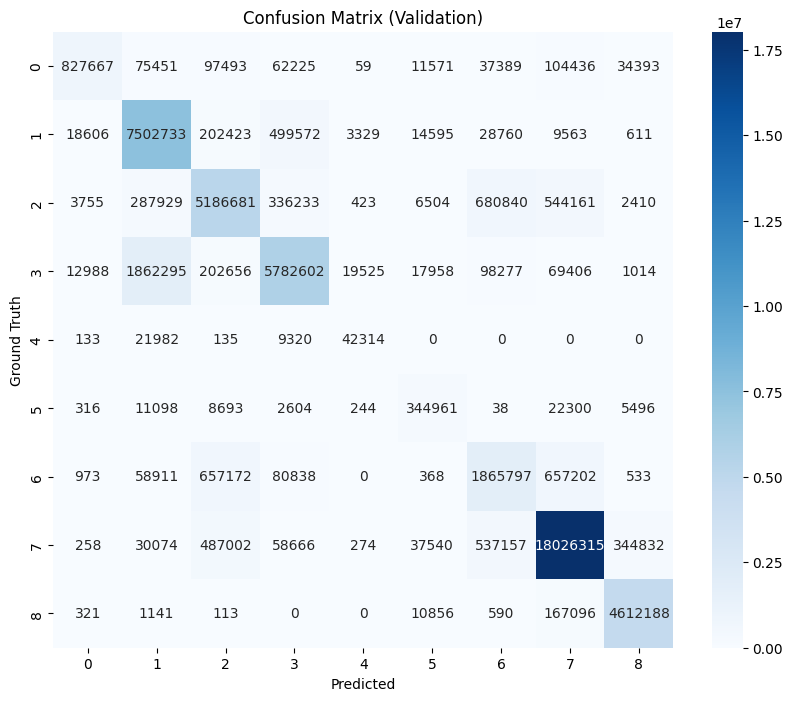


Metriche per classe:
Classe 0: Precision=0.957, Recall=0.662, F1=0.782, IoU=0.643
Classe 1: Precision=0.762, Recall=0.906, F1=0.828, IoU=0.706
Classe 2: Precision=0.758, Recall=0.736, F1=0.747, IoU=0.596
Classe 3: Precision=0.846, Recall=0.717, F1=0.776, IoU=0.634
Classe 4: Precision=0.639, Recall=0.573, F1=0.604, IoU=0.433
Classe 5: Precision=0.776, Recall=0.872, F1=0.821, IoU=0.697
Classe 6: Precision=0.574, Recall=0.562, F1=0.568, IoU=0.397
Classe 7: Precision=0.920, Recall=0.923, F1=0.922, IoU=0.854
Classe 8: Precision=0.922, Recall=0.962, F1=0.942, IoU=0.890

Macro Avg: Precision=0.795, Recall=0.768, F1=0.777, IoU=0.650


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === Parametri di Configurazione ===
num_classes = 9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = "best_model.pth"  # Path relativo standard

# === Caricamento Modello ===
# Si assume che 'model' sia già istanziato correttamente nel notebook/script
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

def fast_confusion_matrix(preds, labels, num_classes):
    # preds e labels devono essere flattenati
    preds = preds.view(-1)
    labels = labels.view(-1)
    mask = (labels >= 0) & (labels < num_classes)
    conf = torch.bincount(
        num_classes * labels[mask] + preds[mask],
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)
    return conf

# === Valutazione Efficiente ===
conf_matrix = torch.zeros((num_classes, num_classes), dtype=torch.long)

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Validazione (Fast)"):
        images = images.to(device)
        masks = masks.to(device)
        output = model(images)
        preds = torch.argmax(output['out'], dim=1)
        # Riportiamo su CPU per l'accumulo della matrice di confusione
        conf_matrix += fast_confusion_matrix(preds.cpu(), masks.cpu(), num_classes)

# === Visualizzazione Matrice di Confusione ===
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix.numpy(), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Validation)")
plt.show()

# === Calcolo Metriche Base ===
TP = conf_matrix.diag()
FP = conf_matrix.sum(0) - TP
FN = conf_matrix.sum(1) - TP

precision = TP / (TP + FP + 1e-6)
recall = TP / (TP + FN + 1e-6)
f1 = 2 * precision * recall / (precision + recall + 1e-6)
iou = TP / (TP + FP + FN + 1e-6)

print("\nMetriche per classe:")
for c in range(num_classes):
    print(f"Classe {c}: Precision={precision[c]:.3f}, Recall={recall[c]:.3f}, F1={f1[c]:.3f}, IoU={iou[c]:.3f}")

print(f"\nMacro Avg: Precision={precision.mean():.3f}, Recall={recall.mean():.3f}, F1={f1.mean():.3f}, IoU={iou.mean():.3f}")

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 🔧 Funzione per denormalizzare un'immagine tensorizzata
def denormalize(img_tensor, mean, std):
    """
    Inverte la normalizzazione torchvision.
    img_tensor: Tensor [C, H, W], normalizzato
    Ritorna: NumPy [H, W, 3] in [0, 1]
    """
    img = img_tensor.clone().detach().cpu().numpy()
    for i in range(3):
        img[i] = img[i] * std[i] + mean[i]
    img = np.clip(img, 0, 1)
    return np.transpose(img, (1, 2, 0))  # [C, H, W] → [H, W, C]

# 🎨 Mappa colori personalizzata (modifica se vuoi)
colormap = ListedColormap([
    '#ffffff',  # 0 - bianco (sfondo)
    '#e0be93',  # 1 - beige
    '#a0ff95',  # 2 - verde chiaro
    '#5e3f20',  # 3 - marrone
    '#ff00ff',  # 4 - fucsia
    '#ff0000',  # 5 - rosso
    '#4fbf4f',  # 6 - verde medio
    '#006400',  # 7 - verde scuro
    '#0000ff',  # 8 - blu
])

# 🖼 Funzione per mostrare l'immagine, la predizione e la GT
def show_segmentation(rgb_tensor, pred_mask, gt_mask, mean, std):
    rgb_np = denormalize(rgb_tensor, mean, std)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(rgb_np)
    plt.title("Immagine Originale")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap=colormap, vmin=0, vmax=8)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap=colormap, vmin=0, vmax=8)
    plt.title("Predizione")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


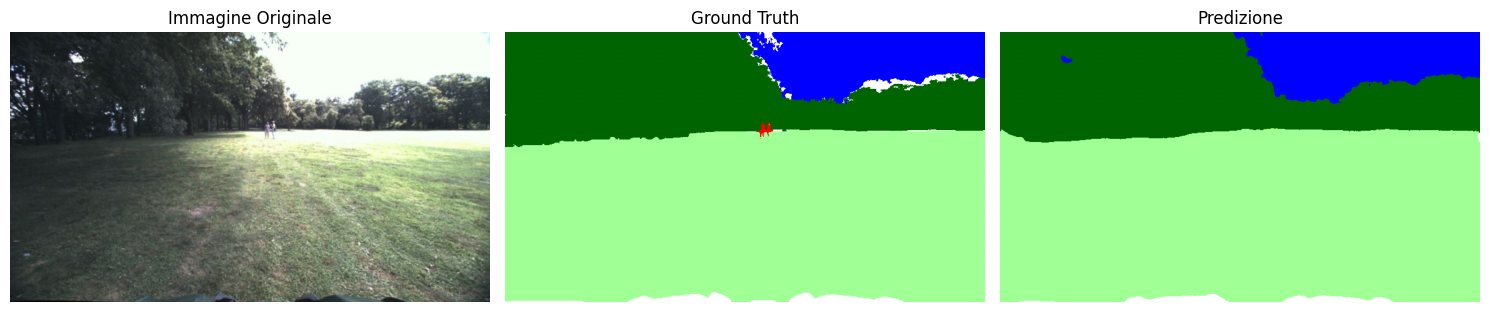

In [ ]:
# Setup iniziale (fuori dalla cella o nella prima esecuzione)
device = "cpu"
model.eval()

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# ⬇ Crea lo stato globale se non esiste già
if 'val_batch' not in globals():
    val_batch = iter(val_loader)
    val_inputs, val_targets = next(val_batch)
    val_index = 0

# ⬇ Quando superi il batch, vai al prossimo
if val_index >= val_inputs.shape[0]:
    try:
        val_inputs, val_targets = next(val_batch)
        val_index = 0
    except StopIteration:
        print("Fine del validation set. Riparto da capo.")
        val_batch = iter(val_loader)
        val_inputs, val_targets = next(val_batch)
        val_index = 0

# ⬇ Estrai l'immagine corrente
image = val_inputs[val_index].to(device).unsqueeze(0)
target = val_targets[val_index].to(device)

# ⬇ Inferenza
with torch.no_grad():
    output = model(image)
    pred = torch.argmax(output['out'], dim=1).squeeze(0).cpu().numpy()

# ⬇ Visualizza
show_segmentation(
    val_inputs[val_index],
    pred,
    target.cpu().numpy(),
    mean, std
)

# ⬆ Avanza l'indice
val_index += 1
